# Documentație proiect - Inteligență Artificială

## Mihai Andrei-Alexandru, grupa 241


>**1. Scopul proiectului.**

&nbsp;&nbsp;&nbsp;&nbsp; Scopul acestui proiect este antrenarea unui model pentru clasificarea unor imagini care prezintă creierul uman pentru a vedea daca acesta prezintă sau nu o anomalie, iar acuratețea modelului să tindă către valori cât mai mari.

>>**1.1 Înțelegerea setului de date.**

&nbsp;&nbsp;&nbsp;&nbsp; Pentru ambele modele care vor fi prezentate, voi folosi:

- **train_images** - imaginile de antrenare, primele 15000 de imagini din folderul *data* [0 : 14999].

- **validation_images** - imaginile pentru validarea modelului, urmatoarele 2000 de imagini din *data* [15000 : 16999].

- **test_images** - imaginile pe care testăm modelul și pentru care programul generează label-uri [17000 : 22149].


- **train_labels** - etichetele imaginilor de antrenare, care specifică dacă creierul din imagine are o anomalie sau nu. Aceste etichete sunt preluate din fișierul *train_labels.txt*.

- **validation_labels** - etichetele imaginilor de validare. Aceste etichete sunt preluate din fișierul *validation_labels.txt*.


>**2. Metode de lucru.**

&nbsp;&nbsp;&nbsp;&nbsp; Concret, în rezolvarea proiectului am testat următoarele modele, prezentate detaliat în continuare: *Multinomial Naïve Bayes*, *Rețele Neuronale Convoluționale*.


>>**2.1	Multinomial Naïve Bayes.**

&nbsp;&nbsp;&nbsp;&nbsp; Primul model pe care l-am încercat a fost Multinomial Naïve Bayes. Pentru task-ul pe care l-am avut de realizat, Bayes nu este un model care care să ofere o acuratețe enormă, dar are ca avantaje rapiditatea cu care rulează, chiar și pe seturi relativ mari de date, dar și implementarea ușoară a programului.


>>>**2.1.1	Citirea datelor.**

&nbsp;&nbsp;&nbsp;&nbsp; Pentru citirea imaginilor am creat 3 funcții care primesc ca parametru path-ul către folderul "data". Pentru fiecare citire, am parcurs lista sortata lexicografic a denumirilor fișierelor din folderul *path* (obținută cu ajutorul bibliotecii **OS**), apoi am citit fiecare imagine prin intermediul bibliotecii **PIL**, am convertit imaginea la greyscale, apoi la un np.array unidimensional.

&nbsp;&nbsp;&nbsp;&nbsp; În continuare am adăugat imaginea la vectorul de imagini definit inițial. După citirea tutoror imaginilor din categoria respectivă, am returnat vectorul de imagini, convertit la np.array.

In [ ]:
# Biblioteci necesare.
import os
import numpy as np
from PIL import Image

# Functie definita pentru citirea datelor de antranare.
# Aceasta primeste ca parametru path-ul catre date.
def readTrainImages(path):
    train_images = []
    # Iteram prin primele 15000 de poze pentru a adauga la train_images
    for filename in sorted(os.listdir(path))[:15000]:
        
        # Incarcam imaginea curenta
        image = Image.open(path + "/" + filename)
    
        # Convertim imaginea curenta intr-o imagine grayscale, apoi convertim la un array 1D
        image_array = np.array(image.convert("L")).flatten()
        
        # Adaugam imaginea curenta la vectorul de imagini, daca imaginea nu este facuta doar din pixeli negrii
        train_images.append(image_array)
        
    # Convertim array-ul imaginilor intr-o np.array si il returnam
    return np.array(train_images)


In [ ]:
# Functie definita pentru citirea datelor de validare
# Aceeasi functionalitate ca cea de sus.
def readValidationImages(path):
    valiadation_images = []

    for filename in sorted(os.listdir(path))[15000:17000]:
        
        image = Image.open(path + "/" + filename)
        
        image_array = np.array(image.convert("L")).flatten()
        
        valiadation_images.append(image_array)
        
    return np.array(valiadation_images)

In [ ]:
# Functie definita pentru citirea datelor de testare - aceeasi functionalitate ca prima
def readTestImages(path):
    test_images = []
    
    for filename in sorted(os.listdir(path))[17000:]:
    
        image = Image.open(path + "/" + filename)
        
        image_array = np.array(image.convert("L")).flatten()
        
        test_images.append(image_array)
        
    return np.array(test_images)

&nbsp;&nbsp;&nbsp;&nbsp; Pentru citirea label-urilor am creat o funcție care primește ca parametru path-ul către fișierul .txt corespunzător setului de date pe care îl citim.

&nbsp;&nbsp;&nbsp;&nbsp; Inițial deschidem fișierul de la path-ul transmis ca parametru, și începând de la a doua linie (prima are rol de header) memorăm într-un tablou (intitulat labels) etichetele corespunzatoare, iar la final se returnează vectorul label-urilor.

In [ ]:
def readLabels(path):
    
    f = open(path)
    
    # Citim prima linie din fisier, care nu contine un label
    f.readline()
    
    labels=[]
    
    # Dintr-o linie memoram doar labelul
    for linie in f.readlines():
        labels.append(int(linie.split(',')[1]))
    f.close()
    
    return labels

Ne definim căile de acces pentru fișiere, apoi citim datele.

In [ ]:
pathImages = "/kaggle/input/unibuc-brain-ad/data/data"
pathLabels = "/kaggle/input/unibuc-brain-ad/data"

train_images=readTrainImages(pathImages)
validation_images=readValidationImages(pathImages)
test_images=readTestImages(pathImages)

train_labels=np.array(readLabels(pathLabels + "/train_labels.txt"))
validation_labels=np.array(readLabels(pathLabels + "/validation_labels.txt"))

>>>**2.1.2	Prelucrarea datelor.**

&nbsp;&nbsp;&nbsp;&nbsp; Pentru prelucrarea datelor am folosit împarțirea celor 3 seturi de date pe intervale. Mi-am definit următoarele 2 funcții:

- *generareIntervale*, care genereaza un numar de *numarIntervale* in care valorile curpinse intre 0 si Max sunt distribuite uniform.

In [ ]:
def generareIntervale(numarIntervale,Max):
    intervale = np.linspace(start=0, stop=Max, num=numarIntervale)
    return intervale

- *valori_intervale*, care transforma matricea x intr-o matrice de *aceeasi dimensiune*, in care pixelii sunt *inlocuiti* cu label-urile intervalului de care apartine.

In [ ]:
def valori_intervale(matrice,intervale):
    newMatix = np.zeros(matrice.shape)
    for i, elem in enumerate(matrice):
        newMatix[i] = np.digitize(elem, intervale)
    return newMatix - 1

&nbsp;&nbsp;&nbsp;&nbsp; Cele 2 variabile care pot influența performanța modelul meu sunt **valoarea maximă** a pixelilor (cea mai apropiată valoare de alb), cât și **numărul de intervale**.

Prin mai multe încercări am ajuns la valoarile următoare: 
- **224** pentru valoarea maximă a pixelilor.
- **4** pentru numărul de intervale.

In [ ]:
intervale=generareIntervale(4,224)
train=valori_intervale(train_images,intervale)
validation=valori_intervale(validation_images,intervale)
test=valori_intervale(test_images,intervale)



Pentru verificare am realizat aceste grafice cu ajutorul **matplotlib**:

- graficul f1 scor-urilor în funcție de limita superioară a pixelilor (generat când datele au fost împărțite în 4 intervale). Ulterior, prin generarea graficului am constatat că există și alte valori mai bune decât 224 (pentru acest set de date), care pot influența performanța modelului. Inițial am vrut să aduc o optimizare, calculând maximul dintre pixeli și utilizarea acestuia ca limită superioară, dar după cum se poate vedea și pe grafic, valoarea maximă nu este neapărat și optimă, deoarece sunt puține imagini în acest set de date sunt puține imagini cu pixeli de valori atât de mari.

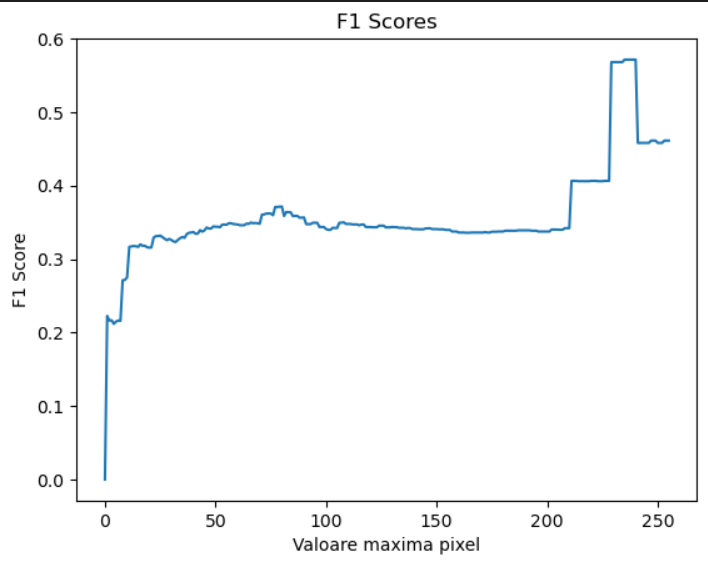

- graficul f1 scor-urilor în funcție de numărul de intervale în care sunt împărțite datele (în raport cu limita superioară a intervalului de pixeli = 224). Se poate observa că în punctul 4, performanța modelului este optimă.

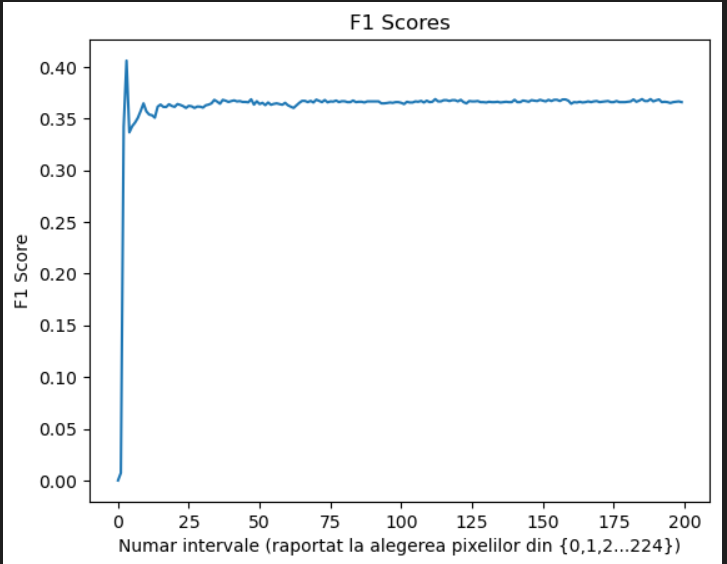

&nbsp;&nbsp;&nbsp;&nbsp; O altă prelucrare a datelor care ar fi putut ajuta la creșterea acurateței modelului este normalizarea datelor. Prin încercări, am observat că normalizarea datelor nu crește performanța modelului (pentru acest set de date, raportat la modelul MultinomialNB), după cum este ilustrat și în graficul următor. Pe axa OX sunt ilustrate următoarele:
- în x=0 -> datele nu au fost normalizate au fost împărțite pe intervale după cum am menționat mai sus.
- în x=1 -> datele au fost normalizate folosind **sklearn.preprocessing Normalizer**, cu norma 'l1', dar nu au fost împărțite pe intervale.
- în x=2 -> datele au fost normalizate folosind **sklearn.preprocessing Normalizer**, cu norma 'l1' și au fost împărțite pe intervale după cum am menționat mai sus.
- în x=3 -> datele au fost normalizate folosind **sklearn.preprocessing Normalizer**, cu norma 'l2', dar nu au fost împărțite pe intervale.
- în x=4 -> datele au fost normalizate folosind **sklearn.preprocessing Normalizer**, cu norma 'l2' și au fost împărțite pe intervale după cum am menționat mai sus.

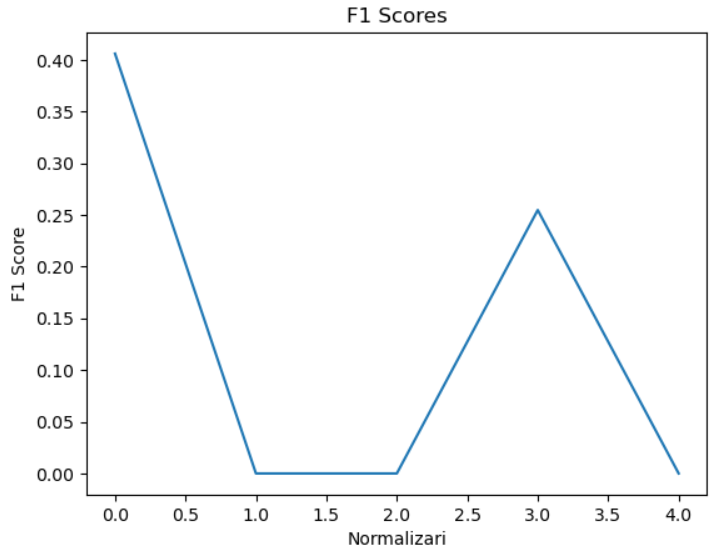

&nbsp;&nbsp;&nbsp;&nbsp; De asemenea, un alt procedeu pe care l-am încercat pentru îmbunătățirea scorului a fost **data augmentation**. Am încercat să adaug la setul de train, pe lângă imaginile de train, anumite imagini din acest set de date, pe care le-am rotit, sau/și le-am dat flip, sperând la îmbunătățirea performanței modelului. Din păcate, performanța se modifica aproape insesizabil, ba chiar în unele cazuri apărea fenomenul de overfitting, deci am decis să renunț la acestă funcționalitate.

>>>**2.1.3	Definirea și antrenarea modelului.**

&nbsp;&nbsp;&nbsp;&nbsp; În continuare, ce rămâne de făcut este să ne definim modelul, să îl antrenăm pe datele de test și să prezicem label-urile datelor de test, în raport cu modul de antrenare și generarea fișierului de output.

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score

bayes = MultinomialNB()
bayes.fit(train, train_labels)

scor = bayes.score(validation, validation_labels)
print("Acuratetea pe datele de validare este: ",scor)

test_labels = bayes.predict(validation)
f1 = f1_score(test_labels, validation_labels)
print("F1 score: ",f1)

test_labels = bayes.predict(test)

stringLabels = []

for i in range(17001, 22150):
    label='0' + str(i) + ',' + str(test_labels[i - 17001])
    stringLabels.append(label)
    
np.savetxt('rezultat.csv', stringLabels, fmt='%s', header="id,class", comments='')

&nbsp;&nbsp;&nbsp;&nbsp; Pentru vizualizarea performanței modelului, am generat și o matrice de confuzie pe care o atașez mai jos, alături de rezultatul f1 score-ului generat:


In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(validation_labels, test_labels)
print(cm)

F1 score: 0.40598290598290604

Matricea de confuzie:
$$\begin{bmatrix} 1254 & 470 \\ 86 & 190 \end{bmatrix}$$


>>**2.2	Convolutional Neural Network (CNN).**

&nbsp;&nbsp;&nbsp;&nbsp; Al doilea model încercat a fost un CNN, model pentru care acuratețea va crește.


>>>**2.2.1	Citirea datelor.**

&nbsp;&nbsp;&nbsp;&nbsp; Pentru citirea imaginilor am creat 3 funcții asemănătoare cu cele de la Bayes, dar care nu mai convertesc imaginile în format greyscale flatten, iar citirea label-urilor este identică cu cea de la modelul anterior.

In [ ]:
# Functie definita pentru citirea datelor de antranare
def readTrainImages(path):
    train_images = []
    # Iteram prin primele 15000 de poze pentru a adauga la train_images
    for filename in sorted(os.listdir(path))[:15000]:
        # print((i,filename))
        
        # Incarcam imaginea curenta
        image = Image.open(path + "/" + filename)
        
        # Adaugam imaginea curenta la vectorul de imagini.
        train_images.append(np.array(image))
        
    # Convertim array-ul imaginilor intr-o np.array si il returnam
    return np.array(train_images)

In [ ]:
# Functie definita pentru citirea datelor de validare - aceeasi functionalitate ca prima
def readValidationImages(path):
    valiadation_images = []

    for filename in sorted(os.listdir(path))[15000:17000]:
        # print((i,filename))
        image = Image.open(path + "/" + filename)
        valiadation_images.append(np.array(image))
        
    return np.array(valiadation_images)

In [ ]:
# Functie definita pentru citirea datelor de testare - aceeasi functionalitate ca prima
def readTestImages(path):
    test_images = []
    
    for filename in sorted(os.listdir(path))[17000:]:
        # print((i,filename))
        image = Image.open(path + "/" + filename)
        test_images.append(np.array(image))
        
    return np.array(test_images)

In [ ]:
# Functie care citeste din fisier label-urile pozelor. 
def readLabels(path,trainData=False):
    
    f = open(path)
    
    # Citim prima linie din fisier, care nu contine un label
    f.readline()
    
    labels=[]
    
    # Dintr-o linie memoram doar labelul
    for linie in f.readlines():
        labels.append(int(linie.split(',')[1]))
    f.close()
    
    return labels

In [ ]:
pathImages = "/kaggle/input/unibuc-brain-ad/data/data"
pathLabels = "/kaggle/input/unibuc-brain-ad/data"

train_images=readTrainImages(pathImages)
validation_images=readValidationImages(pathImages)
test_images=readTestImages(pathImages)
train_labels=np.array(readLabels(pathLabels + "/train_labels.txt"))
validation_labels=np.array(readLabels(pathLabels + "/validation_labels.txt"))

>>>**2.2.2	Definirea modelului.**

&nbsp;&nbsp;&nbsp;&nbsp; Înainte de definirea modelului, am definit următoarea comandă, care specifică sistemului să nu folosească tot VRAM-ul pentru a evita anumite erori de sistem. Alocarea memoriei crește dinamic în funcție de cerințe.

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Lambda
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)


&nbsp;&nbsp;&nbsp;&nbsp; Modelul definit este **Sequential** din *tensorflow.keras.models*, care primește ca parametru lista layerelor, după cum urmează:

In [ ]:
#Definirea modelului
CNN = Sequential([
    Lambda(lambda x: x / 255.0, input_shape=(224, 224, 3)), #normalizam datele printr-un layer lambda
    Conv2D(16, (3,3), 1, activation='relu', input_shape=(224,224,3)),
    MaxPooling2D(),
    Conv2D(32, (3,3), 1, activation='relu'),
    MaxPooling2D(),
    Conv2D(16, (3,3), 1, activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(256, activation='relu'),
    Dense(1, activation='sigmoid') 
])

- Primul layer este de tip **Lambda** are rol în normalizarea datelor, împarte fiecare pixel la valoare maximă (255 - alb) pentru a ne asigura că toate valorile sunt cuprinse între [0,1]. De asemenea, se transmite prin parametru forma imaginii. Pentru setul nostru de date, toate imaginile au forma (224,224,3).

- Al doilea strat pe care l-am adaugat este un strat **convoluțional**, cu 16 de filtre, cu marimea kernel-ului de 3×3 (mărimea matricei care realizează convoluția), numărul de stride-uri egal cu 1 (cați pixeli se mișcă kernel-ul după un pas) si cu functia de activare ReLU. Deoarece acesta este primul strat din retea, am specificat si un input shape de (224,224,1).

- Al treilea strat pe care l-am adaugat este un strat de tipul **MaxPooling2D** reduce dimensiunea datelor selectând valoarea maximă din fiecare kernel de 2x2.

- Următoarele 4 straturi sunt în conformitate cu structura de mai sus: un layer **Conv2D** cu 32 de filtre, urmând un strat de tip **MaxPooling2D**, apoi înca un layer **Conv2D** cu 16 de filtre și un strat de tip **MaxPooling2D**.

- În continuare, am adăugat un layer de tip **Flatten**, care transformă output-ul într-un tablou unidimensional, acest lucru fiind necesar pentru a transmite output-ul către layere care sunt conectate total.

- Următorul strat este de tip **Dense**, cu 256 de unități. Acesta este un strat conectat complet de output-urile de pe stratul anterior.

- Ultimul strat pe care l-am adăugat este tot de tip **Dense**, (la fel, conectat complet de output-urile de pe layer-ul anterior) care are o singură unitate (acest lucru specificând faptul că este un singur output pentru o imagine) și peste care se aplică funcția de activare **Sigmoid**. Acesta se folosește dacă avem un singur rezultat, anume probabilitatea ca imaginea curentă să aparțină unei clase. Folosim functia de activare Sigmoid tocmai pentru că trebuie să ne decidem între 2 clase. Dacă trebuia să decidem între mai multe clase am fi folosit softmax.

>>>**2.2.3	Compilarea modelului.**

&nbsp;&nbsp;&nbsp;&nbsp; În continuare, după ce modelul a fost definit, acesta trebuie compilat, cu acestă comandă.

In [ ]:
CNN.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

 &nbsp;&nbsp;&nbsp;&nbsp; Această linie compilează modelul folosind optimizatorul **Adam**, funcția de pierdere **BinaryCrossentropy** și metrica de acuratețe (**accuracy**). Optimizatorul Adam este o alegere populară pentru antrenarea rețelelor neurale, deoarece adaptează rata de învățare bazată pe funcția de pierdere. 
 
 &nbsp;&nbsp;&nbsp;&nbsp; Funcția de pierdere **BinaryCrossentropy** este potrivită pentru problemele de clasificare binară, unde dorim să minimizăm diferența între etichetele binare prezise și cele reale. 
 
  &nbsp;&nbsp;&nbsp;&nbsp; Metrica de acuratețe (**accuracy**) calculează proporția de imagini clasificate corect în setul de validare.

  ---

&nbsp;&nbsp;&nbsp;&nbsp; Putem vedea exact cum sunt transformate datele din layer în layer, folosind următoarea comandă.

In [ ]:
CNN.summary()

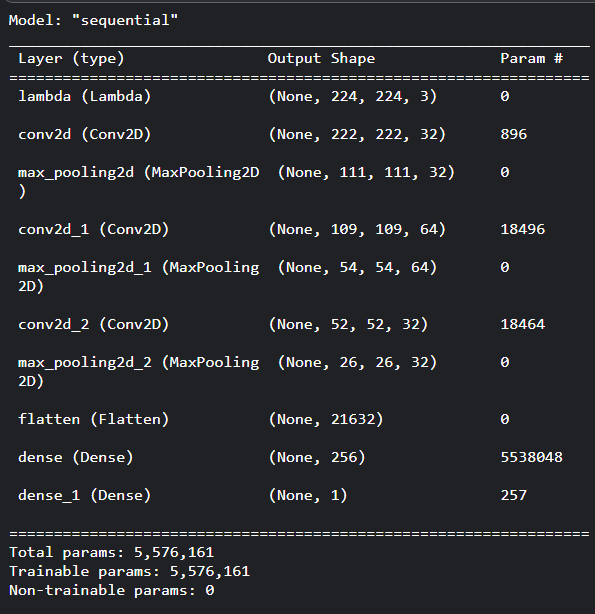

>>>**2.2.4 Antrenarea modelului.**

&nbsp;&nbsp;&nbsp;&nbsp; După ce modelul a fost compilat, acesta trebuie antrenat folosind seturile de date care ne-au fost puse la dispoziție.

In [ ]:
steps='logs'

- Setează numele directorului în care se vor salva jurnalele TensorBoard în timpul antrenării.

In [ ]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=steps)

- În continuare, se creează o funcție de tip callback care va scrie jurnale TensorBoard în timpul antrenării, folosind directorul specificat în variabila steps.

In [ ]:
hist = CNN.fit(train_images,train_labels,validation_data=(validation_images,validation_labels),epochs=20,callbacks=[tensorboard_callback])

- Această linie antrenează modelul CNN pe datele de antrenare (train_images, train_labels) timp de 20 de epoci, folosind datele de validare (validation_images, validation_labels) pentru a evalua performanțele modelului după fiecare epocă de antrenare.

>>>**2.2.5	Prezicerea datelor și generarea fișierului output.**

&nbsp;&nbsp;&nbsp;&nbsp; Ultimul pas este prezicerea label-urilor datelor de test, în raport cu modul de antrenare și generarea fișierului de output.

&nbsp;&nbsp;&nbsp;&nbsp; La final, test_labels conține valori din [0,1], deci le converim în valori tip {0,1}, anume label-ul clasei pe care o are imaginea de test.

In [ ]:
test_labels = CNN.predict(test_images)

# Generam CSV-ul care contine label-urile la care s-a dat predict.
stringLabels = []

# Formam lista de stringuri care se va scrie in CSV.

i=17001
for lab in test_labels:
    if lab > 0.5:
        label='0' + str(i) + ',' + str(1)
    else:
        label='0' + str(i) + ',' + str(0)
    stringLabels.append(label)
    i+=1
    
np.savetxt('rezultat.csv', stringLabels, fmt='%s', header="id,class", comments='')


&nbsp;&nbsp;&nbsp;&nbsp; Pentru vizualizarea performanței modelului, am generat o matrice de confuzie, alături de 2 grafice, pe care le atașez mai jos, alături de rezultatul f1 score-ului:

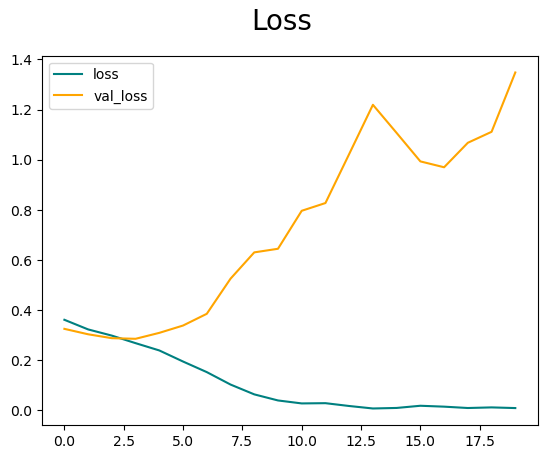

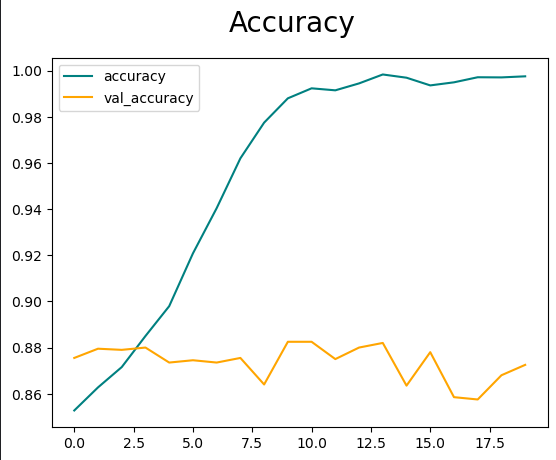

F1 score: 0.4699248120300752

Matricea de confuzie:
$$\begin{bmatrix} 1593 & 131 \\ 151 & 125 \end{bmatrix}$$
